# Geometrical Methods in Machine Learning

## Homework 2

In [ ]:
# !pip install --upgrade Ripser
# !pip install --upgrade persim

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

from sklearn.datasets import load_digits

from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import Ridge
from functools import partial

import os
from PIL import Image
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

from matplotlib import offsetbox

from ripser import ripser
from persim import plot_diagrams

### Task 1: Intrinsic dimension estimation (4 points)

Implement $2$ intrinsic dimension estimation methods from an individual list for your triple (see the assignment). Specify the methods you have chosen in the canvas Homework 2 comments.

Each method should be realized as a Python class implementing public method `fit` as well as providing access to public class variable(s) `dimension` (all methods), `local_dimension`, `dimension_multiscale`, `local_dimension_multiscale` (specific methods).

- `fit` method should return the estimate $\hat{d}$ of the intrinsic dimensionality of the data as well as setting the scalar `dimension` property of the class,
- if the method is _local_, the vector of dimension $n$ `local_dimension` property should be present with `dimension` being their median or mean aggregates along points,
- if the method is _multiscale_, the vector of dimenson $s$ `dimension_multiscale` and the matrix of dimensions $s \times n$ `local_dimension_multiscale` should be present as well, with `dimension` and `local_dimension` being their median or mean aggregates along scales.

Be sure to give a method summary, describing its (see the examples below)
- idea,
- the estimator formula and/or algorithm,
- the reference to pages with estimator derivation, and
- the list of reference(s).

**Grading:** Implementing any single method is awarded with $3$ points, implementing both with $4$ points.

#### Examples

In [48]:
# load data
X, y = load_digits(return_X_y=True)

In [43]:
X.shape

(1797, 64)

In [44]:
X

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

##### MLE

**Idea**

Local intrinsic dimension estimator based on the principle of maximum likelihood to the distances between close neighbors.

**Estimator formula/algorithm**

Let we use $k$ nearest neighbors $\mathbf{x}_1, \dots, \mathbf{k}_n$ of a point $\mathbf{x}$ and $r_j = d(\mathbf{x}, \mathbf{x}_j)$ is the distance from a point $\mathbf{x}$ to the $k$-th nearest neighbor, then the local MLE estimate of the intrinsic dimension is [Levina2005, Eq. 8]

$$\hat{d}_k(\mathbf{x}) = \left[ \frac{1}{k - 1} \sum_{j=1}^{k - 1} \log \frac{r_k(\mathbf{x})}{r_j(\mathbf{x})} \right]^{-1}$$

Averaging over $\hat{d}_k(\mathbf{x})$ gives the intrinsic dimension of the dataset $\mathbf{X}$.

**Estimator derivation**

For derivation see [Levina2005, pp. 3-4].

**References**  
- [Levina2005] Levina, E., Bickel, P. Maximum Likelihood Estimation of Intrinsic Dimension. _Advances in Neural Information Processing Systems (2005)_

In [ ]:
from sklearn.neighbors import NearestNeighbors

class MLE():
    
    def __init__(self, k=5, aggregate="mean", eps=1e-6):
        
        super().__init__()
        
        self.k = k
        self.eps = eps
        
        if aggregate=="mean":
            self.aggregate = np.mean
        elif aggregate=="median":
            self.aggregate = np.median
        else:
            raise ValueError("Aggregate function should be 'mean' or 'median'")
        
    def fit(self, X):
        
        # get distances within up to the k-th nearest neighor for each point
        nn = NearestNeighbors(n_neighbors=self.k).fit(X)
        distances, _ = nn.kneighbors()
        distances += self.eps # fix duplicate points, causing d(x_i, x_j)=0
        
        # get local and global intrinsic dimensions
        log_distance_ratios = np.log(distances[:,self.k-1:self.k] / distances[:,:self.k-1])
        self.local_dimension = ((self.k - 2) ** -1 * np.sum(log_distance_ratios, axis=1)) ** -1
        self.dimension = self.aggregate(self.local_dimension)
        
        return self.dimension

In [ ]:
# create estimator
estimator = MLE()

# fit estimator, returns (global) intrinsic dimension
dimension = estimator.fit(X)

# get estimates of global and local intrinsic dimensions
dimension = estimator.dimension
local_dimension = estimator.local_dimension

dimension, local_dimension.shape

(8.339146894870613, (1797,))

In [ ]:
local_dimension.mean()

8.339146894870613

##### PCA-based

**Idea**

Global dimension estimator corresponding to specified level of explained variance given by the singular value decomposition of the centered data matrix.

**References**  
- [Pearson1901] Pearson, K. On Lines and Planes of Closest Fit to Systems of Points in Space. _Philosophical Magazine (1901)_

In [ ]:
from sklearn.decomposition import PCA

class PCAd():
    
    def __init__(self, explained_variance=0.95):
        super().__init__()
        self.explained_variance = explained_variance
        
    def fit(self, X):
        pca = PCA(n_components=self.explained_variance)
        pca.fit(X)
        self.dimension = pca.n_components_

        return self.dimension

In [ ]:
# create estimator
estimator = PCAd()

# fit estimator, returns (global) intrinsic dimension
dimension = estimator.fit(X)

# get estimate of (global) dimension
dimension = estimator.dimension
dimension

29

#### 1. Projection angle

**Idea**

This method is for local intrinsic dimension estimation. The idea of this method is to estimate the intrinsic dimensionality of a dataset using nearest neighbors and angles between vectors.


**Estimator formula/algorithm**

Let $k=d$ then $(k+1)$-th Nearest Neighbor $X_{(k+1)}$ lies approximately in the subspace $L(X_i, k)$ this means that an angle 

$$
\alpha_i(k) = \arccos \frac{(X_{(k+1)}-X_i, Pr_{L(X_i,k)}(X_{k+1})-X_i)}{|X_{(k+1)}-X_i| \times |Pr_{L(X_i,k)}(X_{(k+1)})-X_i|}
$$

between vector $X_{(k+1)}-X_i$ and its projection $Pr_{L(X_i,k)}X_{(k+1)}$ on subspace $L(X_i,k)$ is small 

Let $\alpha(k) = \frac{1}{n} \sum_{i=1}^{n}|\alpha_i(k)|$ be averaged angle, then Intrinsic dimension is estimated by 

$$
D = \min\{k: \alpha(k) < \text{chosen threshold}\}
$$

**Estimator derivation**

For derivation see [Lecture 5, pp. 31-32].

**References**  
- [Bernstein2023] Bernstein, A. Lecture 5: Intrinsic dimension estimation, Skoltech. (2023)



In [53]:
class projection_angle:
        
    def angle(self,k, X):
        knn = NearestNeighbors(n_neighbors=k+2)
        knn.fit(X)
        angles = []
        for x in X:
            distances, indices = knn.kneighbors([x]) # finding neares neighbors
            indices = indices[:, 1:]
            span = X[indices[0,:-1]]
            vector =  X[indices[0,-1]]
            coefficients = np.linalg.lstsq(span.T, vector, rcond=None)[0]
            projection = span.T @ coefficients

            A, B = vector-x, projection-x

            cosine = A@B/( np.linalg.norm(A)*np.linalg.norm(B) )
            if cosine>1:
                cosine = 1
            elif cosine<-1:
                cosine=-1

            angles.append( np.arccos(cosine) )
            
        return np.mean( angles )
    
    def fit(self, X):
        n = X.shape[1]
        K = list( range(1, n) )
        angles = []
        for k in tqdm(K):
            angles.append( self.angle(k, X) )
        dim = K[np.argmin(angles)]

        # this method return only 1 dim
        self.dimension = dim
        self.local_dimension = dim
        
        return dim

In [55]:
estimator = projection_angle()
dimension = estimator.fit(X)

dimension = estimator.dimension
local_dimension = estimator.local_dimension

print(f'dimension: {dimension}, local_dimension: {local_dimension}')

dimension: 61, local_dimension: 61


#### 2. GeoMLE

**Idea**

This method is for local intrinsic dimension estimation called GeoMLE. By accounting for the geometric properties of the unknown support, the approach corrects the traditional MLE of intrinsic dimension for flat manifolds. It performs this by regressing standard MLEs based on distances to nearest neighbors for different neighborhood sizes. The suggested method also efficiently handles the problem of nonuniform manifold sampling. 

The following code shows the implemented code for GeoMLE from the [source code](https://github.com/stat-ml/GeoMLE).

**Estimator formula/algorithm**

Let's start with creating $M$ bootstrapped datasets $\tilde D_1,..., \tilde D_M$ of the sample $D = \{X_1,...X_n\}$. For each $k$, the following procedure will be repeated. First, we find $k$ nearest neighbors of point $x$ among the points in $\tilde D_j$ bootstrapped dataset for $j=1,...,M$. Then, for $x$ we calculate its distance from its $k$-th nearest neighbor $T_k(x, \tilde D_j)$ and find its dimension $\hat m_k(x,\tilde D_j)$ by MLE approach. 

The average distances to neighbors and MLEs in the following way

$$
\bar T_k(x) = \frac{1}{M} \sum_{j=1}^{M}T_{K}(x, \hat D_j), \quad \bar m_k(x) = \frac{1}{M} \sum_{j=1}^{M} \hat m_k()x, \hat D_j
$$

**Estimator derivation**

For derivation see [Gomtsyan2019, pp. 4-7].

**References**  
- [Gomtsyan2019] Gomtsyan, M., Mokrov, N., Panov, M. \& Yanovich, Y. Geometry-Aware Maximum Likelihood Estimation of Intrinsic Dimension. (2019)




In [7]:
class GeoMLE():
    def __init__(self, k1=10, k2=40, nb_iter1=10, nb_iter2=20, degree=(1, 2),
                 alpha=5e-3, ver='GeoMLE', aggregate="mean", random_state=None, debug=False):
        self.k1 = k1
        self.k2 = k2
        self.nb_iter1 = nb_iter1
        self.nb_iter2 = nb_iter2
        self.degree = degree
        self.alpha = alpha
        self.ver = ver
        if aggregate=="mean":
            self.aggregate = np.mean
        elif aggregate=="median":
            self.aggregate = np.median
        else:
            raise ValueError("Aggregate function should be 'mean' or 'median'")
        self.random_state = random_state
        self.debug = debug
    
    @staticmethod
    def tolist(x):
        if type(x) in {int, float}:
            return [x]
        if type(x) in {list, tuple}:
            return list(x)
        if type(x) == np.ndarray:
            return x.tolist()
    
    @staticmethod
    def drop_zero_values(dist):
        mask = dist[:,0] == 0
        dist[mask] = np.hstack([dist[mask][:, 1:], dist[mask][:,0:1]])
        dist = dist[:, :-1]
        assert np.all(dist > 0)
        return dist
    
    @staticmethod
    def mle_center(X, X_center, k=5, dist=None):
        if len(X_center.shape) != 2:
            X_center = X_center.values.reshape(1, -1)
        if dist is None:
            neighb = NearestNeighbors(n_neighbors=k+1, n_jobs=1,
                                    algorithm='ball_tree').fit(X)
            dist, ind = neighb.kneighbors(X_center)
            dist = GeoMLE.drop_zero_values(dist)
        dist = dist[:, 0:k]
        assert dist.shape == (X_center.shape[0], k)
        assert np.all(dist > 0)
        d = np.log(dist[:, k - 1: k] / dist[:, 0:k - 1])
        d = d.sum(axis=1) / (k - 2)
        d = 1. / d
        intdim_sample = d
        Rs = dist[:, -1]
        return intdim_sample, Rs
    
    @staticmethod
    def fit_poly_reg(x, y, w=None, degree=(1, 2), alpha=5e-3):
        X = np.array([x ** i for i in GeoMLE.tolist(degree)]).T
        lm = Ridge(alpha=alpha)
        lm.fit(X, y, sample_weight=w)
        return lm.intercept_
    
    @staticmethod
    def _func(df, degree, alpha):
        gr_df = df.groupby('k')
        R = gr_df['R'].mean().values
        d = gr_df['dim'].mean().values
        std = gr_df['dim'].std().values
        if np.isnan(std).any():
            std = np.ones_like(std)
        return GeoMLE.fit_poly_reg(R, d, std ** -1, degree=degree, alpha=alpha)
     
    def fit(self, X):
        if self.random_state is None:
            rng = np.random
        else:
            rng = np.random.RandomState(self.random_state)

        nb_examples = X.shape[0]
        dim_space = X.shape[1]
    
        result = []
        data_reg = []
        
        for i in range(self.nb_iter1):
            dim_all, R_all, k_all, idx_all = [], [], [], []
            for j in range(self.nb_iter2):
                idx = np.unique(rng.randint(0, nb_examples - 1, size=nb_examples))
                X_bootstrap = X.iloc[idx]
                neighb = NearestNeighbors(n_neighbors=self.k2 + 1, n_jobs=1,
                                          algorithm='ball_tree').fit(X_bootstrap)
                dist, ind = neighb.kneighbors(X)
                dist = GeoMLE.drop_zero_values(dist)
                dist = dist[:, 0:self.k2]
                assert np.all(dist > 0)
    
                for k in range(self.k1, self.k2 + 1):
                    dim, R = GeoMLE.mle_center(X_bootstrap, X, k, dist)
                    dim_all += GeoMLE.tolist(dim)
                    R_all += GeoMLE.tolist(R)
                    idx_all += list(range(nb_examples))
                    k_all += [k] * len(dim)
    
            data = {'dim': dim_all,
                    'R': R_all,
                    'idx': idx_all,
                    'k': k_all}
    
            df = pd.DataFrame(data)
            if self.ver == 'GeoMLE':
                func = partial(GeoMLE._func, degree=self.degree, alpha=self.alpha)
                reg = df.groupby('idx').apply(func).values.mean()
                data_reg.append(df)
            elif self.ver == 'fastGeoMLE':
                df_gr = df.groupby(['idx', 'k']).mean()[['R', 'dim']]
                R = df_gr.groupby('k').R.mean()
                d = df_gr.groupby('k').dim.mean()
                std = df_gr.groupby('k').dim.std()
                reg = GeoMLE.fit_poly_reg(R, d, std ** -1, degree=self.degree, alpha=self.alpha)
                data_reg.append((R, d, std))
            else:
                assert False, 'Unknown mode {}'.format(self.ver)
            reg = 0 if reg < 0 else reg
            reg = dim_space if reg > dim_space else reg
            result.append(reg)

            self.local_dimension = np.array(result)
            self.dimension = self.aggregate(self.local_dimension)

        if self.debug:
            return np.array(result), data_reg
        else:
            return np.array(result)


In [21]:
estimator = GeoMLE()

X = pd.DataFrame(X)
dimension = estimator.fit(X)

dimension = estimator.dimension
local_dimension = estimator.local_dimension

print(f'dimension: {dimension}, local_dimension: {local_dimension.shape} \n{local_dimension}')

dimension: 19.25495760882219, local_dimension: (10,) 
[19.03970507 19.76141807 18.76222352 19.00621666 18.84306854 18.49489863
 19.44459128 18.68238309 20.18633271 20.32873853]


### Task 2: Manifold learning (4 points)

Obtain `Extended Yale B` face dataset ([download](https://github.com/oleg-kachan/GMML2023/blob/main/hw2/data/CroppedYale.zip)) which is comprised of $100 \times 100$ pixels images of $38$ persons times $64$ illumination conditions. Resize images to $32 \times 32$ pixels. You can do it using `Pillow` ([link](https://pillow.readthedocs.io/), tested) or any other image processing library of your choice.

1. Estimate the intrinsic dimensionality with a method(s) of your choice (methods from task 1 are perfect candidates) and perform dimensionality reduction to the intrinsic dimension $\hat{d}$ and dimensions $2$ or $3$ for visualization purposes using manifold learning methods of your choice.

2. Compute NPR (neigborhood preservation ratio, see [seminar 4](https://github.com/oleg-kachan/GMML2022/blob/main/seminar4/seminar4_solution.ipynb)) of algorithms you have used for 2 different values of $d = \{2$ or $3, \hat{d} \}$ and fixed number of nearest neighbors $k$. 

3. Explore the embedding space of dimension $2$ or $3$ for clusters and meaningful interpretations, comment the possible meaning of the new coordinates.

4. Compute and plot persistence diagrams for dimensions $0$ and $1$, conclude whether the dataset have untrivial topology such a several clusters and/or presence of cycles in dimension $1$. If applicable, how can one explain a presence of cycles for the `Extended Yale B` face dataset?

**Grading:** Each subtask is awarded with $1$ point.

##### read data and resize

In [8]:
# your code here

def read_data(path):

    # ---------- collect all paths ---------- 

    file_paths = []
    for dir, subdirs, files in os.walk(path):
  
        for subdir in subdirs:
            subdir_path = os.path.join(dir, subdir) 
            file_names = os.listdir(subdir_path)

            all_files_subdir = []
            
            for file_name in file_names:
                path_i = os.path.join(subdir_path , file_name)
                all_files_subdir.append(path_i)
            
            file_paths.append(all_files_subdir)
            
    # ---------- resize images ---------- 

    X = []
    y = []
    img_idx = 0

    for file_path_idx in file_paths:
        for path_idx in file_path_idx:
            if ((str(path_idx)[-3:]=='pgm') | (str(path_idx)[-3:]=='bad')) & (str(path_idx)[-11:]!='Ambient.pgm'):
                img = Image.open(path_idx) 
                # convert to gray scale
                img = img.convert("L")  
                # resize
                img = img.resize((32, 32), Image.NEAREST)   

                X.append(np.asarray(img))  
                y.append(img_idx)

        img_idx += 1

    return X, y, file_paths

In [13]:
path = "./CroppedYale"
X , y, file_paths = read_data(path)

len(X) == 38*64, len(y) == 38*64

(True, True)

In [15]:
# ---------- reshape X for the next step ----------

X_ori = np.array(X)
X = X_ori.reshape(X_ori.shape[0], X_ori.shape[1] * X_ori.shape[2])
print(X.shape)

(2432, 1024)


##### 1. Estimate the intrinsic dimensionality with a method(s) of your choice (methods from task 1 are perfect candidates) and perform dimensionality reduction to the intrinsic dimension $\hat{d}$ and dimensions $2$ or $3$ for visualization purposes using manifold learning methods of your choice.

**Estimate intrinsic dimensionality with GeoMLE**

For this method, the data has to be transformed before applying GeoMLE.

In [16]:
X_std = MinMaxScaler().fit_transform(X)
data_std = pd.DataFrame(X_std)
data_std.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.337255,0.356863,0.447059,0.462745,0.529412,0.529412,0.568627,0.549020,0.635294,0.682353,...,0.321569,0.298039,0.294118,0.156863,0.200000,0.180392,0.149020,0.168627,0.149020,0.082353
1,0.380392,0.411765,0.501961,0.537255,0.607843,0.596078,0.650980,0.666667,0.737255,0.792157,...,0.345098,0.274510,0.262745,0.137255,0.168627,0.113725,0.090196,0.086275,0.058824,0.031373
2,0.337255,0.431373,0.552941,0.592157,0.592157,0.615686,0.725490,0.772549,0.815686,0.862745,...,0.309804,0.223529,0.196078,0.117647,0.098039,0.039216,0.039216,0.031373,0.019608,0.011765
3,0.070588,0.094118,0.105882,0.098039,0.129412,0.145098,0.200000,0.231373,0.243137,0.262745,...,0.023529,0.023529,0.019608,0.007843,0.015686,0.015686,0.015686,0.019608,0.027451,0.011765
4,0.301961,0.317647,0.360784,0.380392,0.419608,0.407843,0.443137,0.482353,0.498039,0.509804,...,0.309804,0.270588,0.258824,0.164706,0.176471,0.192157,0.172549,0.192157,0.164706,0.105882


In [ ]:
estimator = GeoMLE(nb_iter1=20)
dimension = estimator.fit(data_std)

dimension = estimator.dimension
local_dimension = estimator.local_dimension
print(f'dimension: {dimension}, local_dimension: {local_dimension.shape} \n{local_dimension}')

dimension: 9.008976612325101, local_dimension: (20,) 
[9.00534184 8.96173742 9.08648925 8.90030595 8.75580449 9.01975901
 9.11277267 8.96295793 9.06845184 9.09990241 9.1048922  8.76635714
 9.18269614 8.96001588 9.12268373 9.03865335 9.02045023 8.85079471
 9.22504508 8.93442097]


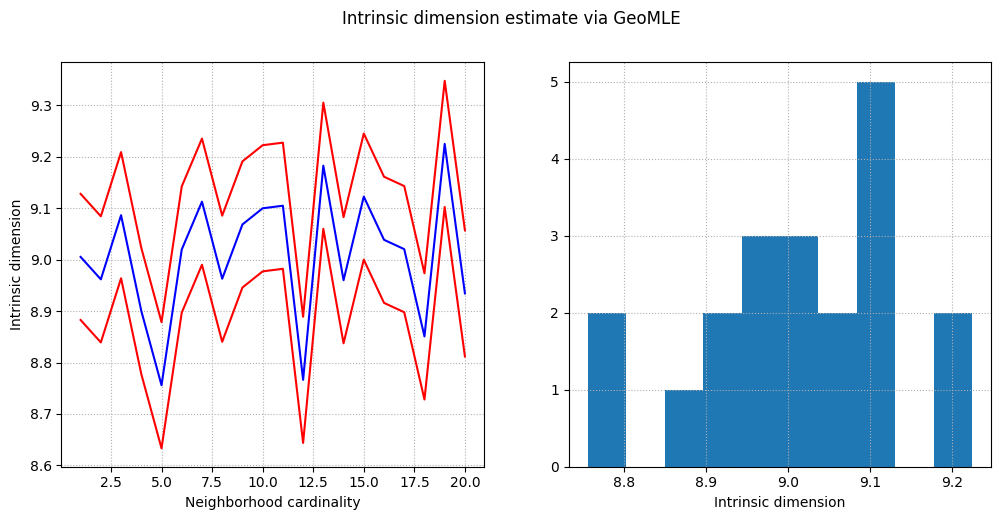

In [ ]:
fig = plt.figure(figsize=(12,5.25))
plt.suptitle("Intrinsic dimension estimate via GeoMLE")

plt.subplot(121)
plt.xlabel("Neighborhood cardinality")
plt.ylabel("Intrinsic dimension")
plt.grid(linestyle='dotted')

# According to I set nb_iter1 (number of bootstrap iterations) = 20 as default   
iter = [i for i in range(1, 20+1)]
plt.plot(iter, local_dimension, 'b')
plt.plot(iter, local_dimension + np.std(local_dimension, axis=0), 'r')
plt.plot(iter, local_dimension - np.std(local_dimension, axis=0), 'r')

plt.subplot(122)
plt.xlabel("Intrinsic dimension")
plt.grid(linestyle="dotted")

plt.hist(local_dimension)
plt.show()

So, we can approximate the intrinsic dimension with GeoMLE with dimension = $9$.

**Reduce dimension by PCA**

In [17]:
# choose instrinsic dimension = 2

model = PCA(n_components=2)
data_d2 = MinMaxScaler().fit_transform(model.fit_transform(X))
data_d2.shape

(2432, 2)

In [18]:
# intrinsic dimension = 9 by GeoMLE

model = PCA(n_components=9)
data_geo = MinMaxScaler().fit_transform(model.fit_transform(X))
data_geo.shape

(2432, 9)

**Reduce dimension by Isomap**

In [19]:
# choose instrinsic dimension = 2

model = Isomap(n_components=2)
X_kpca_d2 = MinMaxScaler().fit_transform(model.fit_transform(X))
X_kpca_d2.shape

(2432, 2)

In [20]:
# intrinsic dimension = 9 by GeoMLE

model = Isomap(n_components=9)
X_kpca_geo = MinMaxScaler().fit_transform(model.fit_transform(X))
X_kpca_geo.shape

(2432, 9)

**Visualization for $d=2$**

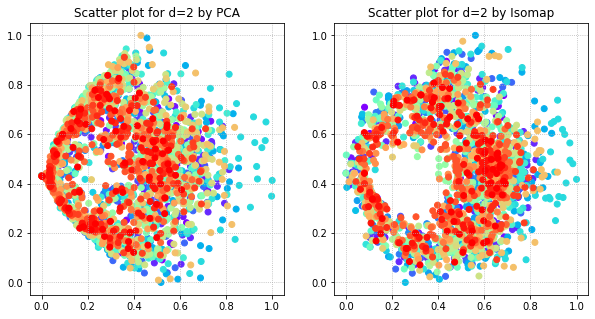

In [28]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.grid(linestyle="dotted")
plt.scatter(data_d2[:, 0], data_d2[:, 1], c=y, cmap=plt.cm.rainbow)
plt.title('Scatter plot for d=2 by PCA')

plt.subplot(1, 2, 2)
plt.grid(linestyle="dotted")
plt.scatter(X_kpca_d2[:, 0], X_kpca_d2[:, 1], c=y, cmap=plt.cm.rainbow)
plt.title('Scatter plot for d=2 by Isomap')
plt.show()

**Visualization for $d=9$ in the first 3-dimension**

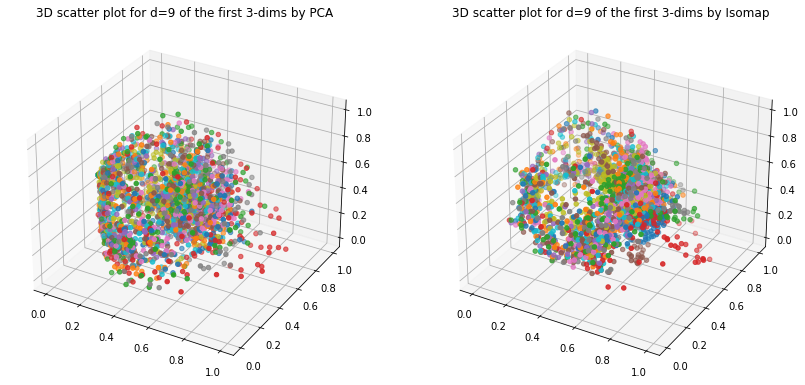

In [37]:
fig = plt.figure(figsize=(14, 7))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(xs = data_geo[:, 0],  ys = data_geo[:, 1],  zs = data_geo[:, 2], c=y, cmap='tab10')
plt.title("3D scatter plot for d=9 of the first 3-dims by PCA")

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(xs = X_kpca_geo[:, 0],  ys = X_kpca_geo[:, 1],  zs = X_kpca_geo[:, 2], c=y, cmap='tab10')
plt.title("3D scatter plot for d=9 of the first 3-dims by Isomap")

plt.show()

##### 2. Compute NPR (neigborhood preservation ratio, see [seminar 4](https://github.com/oleg-kachan/GMML2022/blob/main/seminar4/seminar4_solution.ipynb)) of algorithms you have used for 2 different values of $d = \{2$ or $3, \hat{d} \}$ and fixed number of nearest neighbors $k$. 

In [21]:
def NPR(X, Z, k=10):
    
    _, neighborhood_X = NearestNeighbors(n_neighbors=k).fit(X).kneighbors(X)
    _, neighborhood_Z = NearestNeighbors(n_neighbors=k).fit(Z).kneighbors(Z)
    
    n = X.shape[0]
    npr = 0
    for i in range(n):
        npr += np.intersect1d(neighborhood_X[i], neighborhood_Z[i]).shape[0]
    
    return npr / (k * n)

In [38]:
k =10
print(f'NPR for reduced dimension = 2 by PCA : {NPR(X, data_d2, k)}')
print(f'NPR for reduced dimension = 9 by GeoMLE and PCA : {NPR(X, data_geo, k)} \n')
print(f'NPR for reduced dimension = 2 by Isomap : {NPR(X, X_kpca_d2, k)}')
print(f'NPR for reduced dimension = 9 by GeoMLE and Isomap : {NPR(X, X_kpca_geo, k)}')

NPR for reduced dimension = 2 by PCA : 0.22072368421052632
NPR for reduced dimension = 9 by GeoMLE and PCA : 0.5321134868421052 

NPR for reduced dimension = 2 by Isomap : 0.20189144736842105
NPR for reduced dimension = 9 by GeoMLE and Isomap : 0.5476973684210527


Applying GeoMLE as a method to find intrinsic dimension before apply manifold learning methods can give the good result in neigborhood preservation ratio.

##### 3. Explore the embedding space of dimension $2$ or $3$ for clusters and meaningful interpretations, comment the possible meaning of the new coordinates.

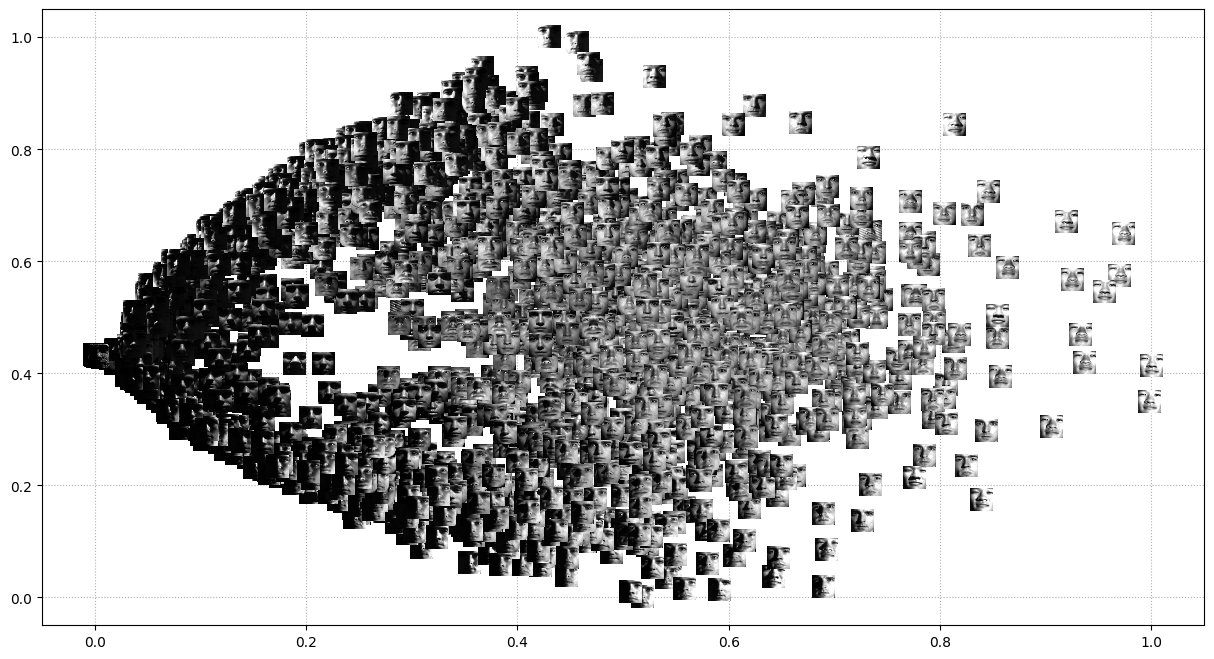

In [48]:
plt.figure(figsize=(15, 8))
plt.grid(linestyle="dotted")
plt.scatter(data_d2[:, 0], data_d2[:, 1], c =y , cmap=plt.cm.rainbow)
shape = (int(np.sqrt(X.shape[1])), int(np.sqrt(X.shape[1])))
ax = plt.gca()
for i in range(0, X.shape[0], 1):
    box = offsetbox.AnnotationBbox(offsetbox.OffsetImage(X[i].reshape(shape), 
                                    cmap="gray", zoom=0.5), data_d2[i], frameon=False)
    ax.add_artist(box)
plt.show()


As we can see from the graph, the images located on the left side are darker than the right side. We can imply that these 2 dimensions can give us the information about contrast and brightness.


##### 4. Compute and plot persistence diagrams for dimensions $0$ and $1$, conclude whether the dataset have untrivial topology such a several clusters and/or presence of cycles in dimension $1$. If applicable, how can one explain a presence of cycles for the `Extended Yale B` face dataset?

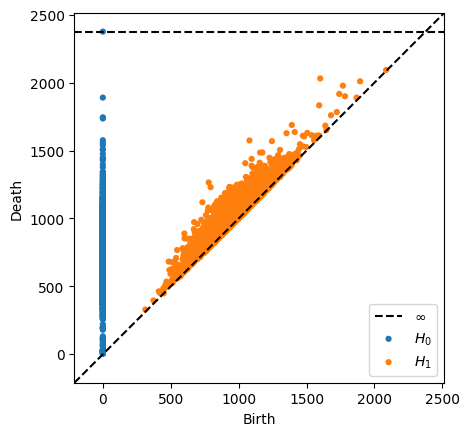

In [50]:
diagrams = ripser(X, maxdim=1)['dgms']
plot_diagrams(diagrams, show=True)

The persistence diagrams for dimensions 0 and 1 are computed using the Ripser package. The legend shows which dimensions (0 and 1) correlate to which persistence diagrams. The persistence diagrams show that the dataset has a nontrivial topology since we can find clusters and cycles, which we can see at the outlier of the orange point clusters in dimension 1.

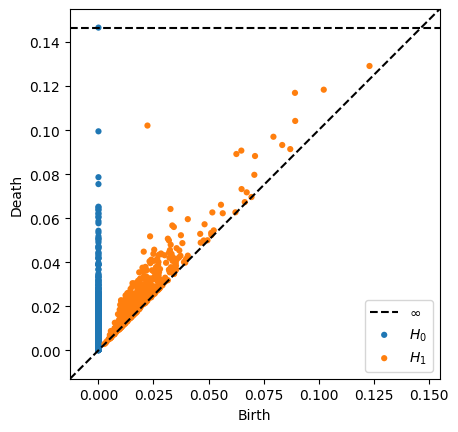

In [14]:
# Let's check persistence diagrams for data_d2

diagrams = ripser(data_d2, maxdim=1)['dgms']
plot_diagrams(diagrams, show=True)

It is evident that it has clusters and cycles when compared to data_d2 (dimension=2, using PCA).

So, for this Extended Yale B face dataset, which contains photos of human faces collected in various lighting situations. Cycles may be seen in dimension 1, which may suggest the presence of face features or structures that endure across multiple lighting situations. These cycles may correspond to patterns like eye sockets, brows, or mouth areas that remain constant despite changes in light.

#### Grading:

- 8/10 points are awarded for completing all the tasks and giving proper answers to questions.
- 2/10 points are awarded for the quality of reporting, be sure to give explanations and comments to your solutions.
- +1 extra point may be awarded for the extra work performed, be creative.